<a href="https://colab.research.google.com/github/Vikadie/AI-repo/blob/master/NER_and_Entity_Linking_in_legal_documents_in_Bulgarian_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import os
from random import randint, seed
from time import time
import json
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

!pip install nose

from nose.tools import *

     |████████████████████████████████| 163kB 17.3MB/s 


In [3]:
!pip install -q -U tf-models-official
!pip install -q -U tensorflow-text

     |████████████████████████████████| 1.1MB 19.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.2MB 51.0MB/s 
     |████████████████████████████████| 174kB 43.5MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 645kB 56.6MB/s 
     |████████████████████████████████| 358kB 47.9MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 
     |████████████████████████████████| 3.4MB 22.5MB/s 


In [4]:
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_text as text  # A dependency of the preprocessing model

from official.nlp import bert
from official.nlp.bert.tokenization import FullTokenizer

tf.get_logger().setLevel('ERROR')

In [5]:
# import sys

# !test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
# if not 'bert_repo' in sys.path:
#   sys.path += ['bert_repo']

In [6]:
# # import python modules defined by BERT
# import modeling

In [7]:
from official.nlp.optimization import AdamWeightDecay, WarmUp
from tensorflow_addons.metrics import F1Score

# NER and Entity Linking in unstructured legal documents in Bulgarian language

##### Final exam report

*Viktor Belchev - student*

*Deep Learning - Software University*

*February 2021*

## Abstract

Abstract

In all legal documents there is usage of citation of different laws or other juridical terms often hidden behind some abbreviations. While this aims to make the text shorter and clearer it is mostly causing troubles in understanding and translation to simple language not only to regular persons, but sometimes even lawyers and people with juridical background feel lost. Therefore, it often requires an additional research in the legal litterature. At this stage another problem might occur - the correct decoding of abbreviated terms can become obstacle on top of the the overall understanding of the information.

In this paper, I will try to use the modern approach of Deep Learning to create a helpful tool that overcomes these problems. Using the state-of-the-art available models in the field of Natual Language Processing like BERT and an abbreviation list available at this stage, I will try to achieve an acceptable accuracy in this task for Bulgarian language that is known as combination of two different tasks: Named Entity Recognition and Entity Linking. 

## Introduction

Generally, in Natural Language Processing (further, NLP) the process of disambiguation of terms is known as Entity Linknig (further, EL), which goes hand in hand with another operation called Named Entity Recognition (further, NER). As explained by Iva Marinova in her **"Reconstructing NER Corpora: a Case Study on Bulgarian"** while in the field of Deep Learning 
these two related tasks are considered to be well covered in
NLP for Germanic, Romance and other language groups,
they are still under-resourced for the Slavic languages, especially from a multilingual perspective.

Usually, the order of application of both tasks is by starting with NER.

The purpose of NER is to tag words in a sentences based on some predefined tags, in order to extract some important information of the sentence, like for instanse names, geographical locations, dates, currency etc.
In NER, each token in the sentence will get tagged with a label, the label will tell the specific meaning of the token. In that way, through NER, we can analyze the sentence with more details and extract the important information.

There are two popular approaches for NER:
- multi-class classification based where NER is treated as a multi-class classification process, and we can use some text classification method to label the token.
- Conditional Random Field(CRF) based method labels the token taking context into account, then predicts sequences of labels for sequences of sentence token then get the most reasonable one. It is a probabilistic graphical model.

The identification of named entity mentions in texts is often implemented using a sequence tagger, where each token is labeled with an BIO tag, indicating whether the token begins a named entity — (B-), whether it is inside of a named entity (I-), or outside of a named entity (O-). This type of annotation has been proposed for the first time at CoNLL-2003 dataset created for NER (Tjong Kim Sang and De Meulder, 2003). There are other tag notation types. For instance, each token can be predicted with a tag indicated by B-(begin), I-(inside), E-(end), S-(singleton) of a named entity with its type, or O-(outside) of named entities. But, I will stick to BIO format of representation for simplicity.

Entity linking can be applied rigth after the NER task is performed althought in some papers on this topic there is proposal to do it in parallel (jointly) for each token, so that each subtask benefits from the partial output of the other subtask, and thus alleviate error propagations that are unavoidable in pipeline settings. 
Generally, EL is the task of mapping words from text (e.g. names of persons, locations and organizations) to entities from the target knowledge base. For this pupose I use a document containing most of the existing abbreviations used in legal documents.

## NER

Usually, no matter the specific task, Deep Learning models creation is based on big data for training, validation and test. For Bulgarian language generally such data could be available if we start scraping web pages, which is huge amount of work. But this is only one side of the hidden obstacles - the effectiveness of the model created for the task is a real challenge on its own. 

Luckily, after the publication of the famous paper called "Attention is all you need" by Vaswani and the "appearance" of *Transformer*, there is a huge advancement in the model creation compared to previous usage of recurrence (RNN), Bidirectional Lont-Short Term Memory units (BiLSTM), convolutions (CNN) and CRF. Transformer utilizes stacked self-attention and pointwise, fully connected layers to build basic blocks for encoder and decoder.  Experiments on various tasks show Transformers to be superior in quality while requiring significantly less time to train.

Based mostly on transformer, it already exists pre-trained models that provide results pretty close to humans on some general tasks. Some of the most used methods are ELMo(Embeddings from Language Models), OpenAI GPT (Generative Pre-trained Transformer), BERT (Bidirectional Encoder Representations from Transformers)... 

It is important to underline that these state-of-the-art models use specific representation of the text, called embeddings, usually so called *hybrid representation* of text in low dimensional real-valued dense vectors. It is called *hybrid* as it uses *Word-level* and *Character-level* representation along with some additional features, where each dimensions represents a latent feature. This way it also captures the semantic and syntactic properties of words, but also the context for each word.

In recent years, the advancements of NLP in general and NER in particular has been greatly influenced by deep transfer learning methods capable of creating contextual representations of words, to the extent that many of the state-of-the-art NER systems mainly differ from one another on the basis of how these contextual representations are created. Using such models, sequence tagging tasks are often approached one sentence at a time, essentially discarding any information available in the broader surrounding context, and there is only little recent study on the use of cross-sentence context – sentences around the sentence of interest – to improve sequence tagging performance.

Precisely for the fact of using this cross-sentence context, but also with the advantage to be pre-trained on Bulgarian texts, in this notebook, I focus on the recent BERT deep transfer learning models based on self-attention and the transformer architecture. BERT uses a fixed-size window that limits the amount of text that can be input to the model at one time. The model maximum window size, or maximum sequence length, is fixed during pre-training, with 512 wordpieces a common choice. This window fits dozens of typical sentences of input at a time, allowing the inclusion of extensive sentence context.

There are many advantages that pushed me towards usage of BERT. To enumerate some, I would say that it provides:
1. quicker development
2. overcome the problem of missing data for training, which is generally the case for Bulgarian
3. state-of-the-art better results - BERT is built on top of a number of clever ideas considered top in NLP community in latest years – including but not limited to Semi-supervised Sequence Learning (by Andrew Dai and Quoc Le), ELMo (by Matthew Peters and researchers from AI2 and UW CSE), ULMFiT (by fast.ai founder Jeremy Howard and Sebastian Ruder), the OpenAI transformer (by OpenAI researchers Radford, Narasimhan, Salimans, and Sutskever), and the Transformer (Vaswani et al).

BERT is also one of the preferred model giving the best results used by Ilias Chalkidis et al. when dealing with  Large-Scale Multi-Label Text Classification (LMTC) in the legal domain (EU legislation).

On the other hand, there are some disadvantages, like:
1. it is very large. The LARGE version of BERT would provide better results, but unfortunately that would require bigger computational ability and time.
2. Even when using the BASE version, it remains slow for fine-tuning.
3. The multilingual version that I need to use cannot be disitilled - the vocabulary used for fine-tuning of BERT must remain the original one.
4. It uses a specific and a bit complicated jargon (domain-specific language), meaning that the tokenization with BERT should be done with BERT Tokenizer.

The last two disadvantages represent in fact the specifity and maybe the strength of BERT. Its vocabulary is indeed fixed, but it has the capability to break down the unknown word into subwords and makes a token out of each subword (if subword exists in the vocabulary). In case the subword do not exist in the vocabulary it can continue spliting it into subwords down to a character level. To recognize the subword it prepends it with "##" flag, exceot for the first subword.

On its turn the subword split would create a problem with labeling. Generally, in the test and train part each word is tagged. If an unknown word is splitted to subwords, a specific tag should be used for it, that would indicate that the tag valid for this word (the initial whole word) would be the one given to the first subword (original word) and a specific tag would be assigned to subwords after the first one.

### Dataset creation

Before getting to the problem of tags given to subwords, we need a dataset, big enough, that can be used to fine-tune our BERT model. This dataset should implement the following requirements:
   - it must be created for a NER task;
   - it must be in Bulgarian;
   - it must contain special annotations (tags) for recognition of legal phrases;
   - it must be big enough to train deep network model;
   - ideally it should have a train, validation and test datasets.

Well, the first four requirements need to be mandatory fulfilled. After all if the dataset is big enough there are ways and methods to make a consise split for train, validation and test datasets. 

But it is hard task to implement all four requirements. In fact, I was not able to find such dataset on Internet. Luckily, there is one dataset recently created for NER task, which was in Bulgarian - the dataset done by Iva Marinova et al. pesented in May 2020. The dataset is available at https://github.com/usmiva/bg-ner. With it, I could cover half of the requirements for my task. Unfortunately, as it was not created for utilization on legal texts, there were not a specific tag for legal phrases inside. Still, it was the best one I could find. Therefore, I decided to use it as a base, a starting point, and add to it the required information covering the legal part gathered by me.

But before start adding information, let me reveal what and how is implemented inside, in order to decide at what level it will suit me and how to add the missing information.

The original Bulgarian corpus consists of 916 text files extracted from various news websites. The training dataset contains information on two topics – Brexit and the trial of the Pakistani Christian Asia Bibi, accused of blasphemy, while the main subjects for the test data are the Nord Stream 2 project and the recent developments in RyanAir’s business history.

The type of annotation used inside followed the format used for the first time at CoNLL-2003 but used only the first and the last column (ommitting the part-of-speech tag and synctatic chunk tag) - meaning that the input files were segmented into sentences and tokens per line (first column), and each token was combined with its corresponding Named Entity tag (the second column). The NE tags were of type person (PER), organization (ORG), location (LOC), product (PRO), and event (EVT) and each of them had a prefix using the BIO format. Like in most NER tasks, NEs are considered to be non-recursive, non- overlapping, and whenever one NE is embedded in another NE, only the top-most entity is annotated.

The 2 files available for download were 2 text files (.txt) - one train file with 220 700 lines and one test file with ~65 000 lines.

Well, armed with this information, it was obvious that the missing part was for legal phrases, thus missing tag for tham. I decided that I could simply add a NE tag LAW. After a quick review there were only few word that could match this new tag in the existing dataset.

Therefore, I added to the training file 117 documents taken from the "Decision Register" of [The Administrative Court of Sofia City (ASCS)](http://www.admincourtsofia.bg/Default.aspx?alias=www.admincourtsofia.bg/en) representing  the first 5 working days of year 2021 (from 4.01 to 8.01.2021). Each of this document was transformed to text, the sentences containing legal mentions were extracted and transformed in a file following the format of the original dataset using a simple Python script. The tag were than manually reviewed and annotated as correctly as possible not forgeting the initially available tags for person, organization etc. with the BIO prefixes.

In that way the train document grew up to 347 642 lines. 

The original test documant were split in two - one for validation and one for test datasets. 40 documents  from the same source (court decisions published from 11.01.2021) were annotated and splitted the same way it was done for the train part. With that operation the validation file consisted of 56 880 lines and the test file of 56 908 lines. 

In that way the ration train vs. validation was assured to be at the reasonable 84% / 14% level.

### Selecting the model and loading it

First, I need to upload the BERT model. The choosen model by is:
- the BERT Multilanguage version (in order to have a pre-trained model that has already seen Bulgarian language and Bulgarian words are part of it vocabulary);
- the Cased version, meaning that whether the words contains capital letter or not matter to the model;
- BASE version, as using the LARGE model would take too many ressources for training without such significal improvement in the outcome.

When using BERT one must be aware that the tokenization with BERT should be done with BERT Tokenizer. There are also other mandatory requirement for the fine-tunning of BERT - used vocabulary should be exactly the original of the pre-trained model.

There are two ways to upload the model.

The first one is by loading the model from TensoFlow Hub:

In [8]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12' 
map_name_to_handle = {'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'}

map_model_to_preprocess = {'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


Using TensoFlow Hub has the advantage of having its incorporated "pre-processing" procedure based on which it can automatically load the required preprocessing model. This model can be loaded into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose a fine-tuned model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
tok = bert_preprocess_model(['Hello TensorFlow!'])
print(f'Keys       : {list(tok.keys())}')
print(f'Shape      : {tok["input_word_ids"].shape}')
print(f'Word Ids   : {tok["input_word_ids"][0, :12]}')
print(f'Input Mask : {tok["input_mask"][0, :12]}')
print(f'Type Ids   : {tok["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 31178 16411 28919 11565 27863   106   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


After loading it and conducting a trial on a brief sentence, it is visible that it outputs a dictionary containing all the three mandatory inputs: *'input_word_ids', 'input_mask'* and *'input_type_ids'*.
It is important to note also that the input is truncated to 128 tokens. Luckily, the number of tokens can be customized. Also, to the `input_word_ids` we can see automatical append of other required tags at the beginning and at the end of the sentence. It is interesting to note as well that the `input_type_ids` only have zeros (0) because this is a single sentence input, which is the case of the NER task as well. For other tasks where there are multiple sentence input, it would have one number for each input.

This "preprocessing" model simplifies a lot the work required by the model, but unfortunately, along with the 'attribute' part, in NER task I have to make the appropriate transformation on the 'label' part as well.

This is what led me to the second possibility, which consists in downloading the required version to a directory from where it can be directly loaded. It can be done with 2 line of code:

`model_name = "multi_cased_L-12_H-768_A-12"`

`model_dir = bert.fetch_google_bert_model(model_name, gs_folder_bert)`

I did that in my Google Disk drive:

In [10]:
gs_folder_bert = '/content/drive/MyDrive/Colab Notebooks/bert_model/'

tf.io.gfile.listdir(gs_folder_bert)

['.ipynb_checkpoints',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_config.json',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt']

In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=False)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 119547


We can use the same example as above on a simple sentence that is not transformed to a list to verify that the upper case matters:

In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['Hello', 'Ten', '##sor', '##F', '##low', '!']
[31178, 16411, 28919, 11565, 27863, 106]


### Constants

I will position the "*Constants*" section here as some of the constants will be used in the next section. As thing progress I will add below all *constant values* that I will use with some explanation below.

In [13]:
EPOCHS = 3  # Total number of training epochs to perform
MAX_SEQ_LENGTH = 256  # the length of the biggest sentence
BATCH_SIZE = 16  # Total batch size for training.
LEARNING_RATE = 5e-5  # The initial learning rate for Adam.
WARM_UP_PROPORTION = 0.1  # Proportion of training to perform linear learning rate warmup for. e.g., 0.1 = 10% of training.
WEIGHT_DECAY = 0.01  # Weight decay if we apply some
ADAM_EPSILON = 0.01  # Epsilon for Adam optimizer
SEED = seed(42)

As "prescribed" on the official [GitHub page of BERT](https://github.com/google-research/bert) in order to avoid any out-of-memory issues when using BERT model `MAX_SEQ_LENGTH` should be up to 512. Having in mind the numerous splits of the specific `tokenizer` of BERT and the maximum tokens length found during the creation of the dataset, I fix the maximum sequence length to `256`. It might not be enough as we have additional split of words to subwords due to BERT specifity, but makeing it bigger will require to much memory and will decrease teh speed of the process. In the case of maximum sequence set on '256', the benchmark of the `BATCH_SIZE` found in the same place is `16`.

For the initial learning rate (`LEARNING_RATE`), in line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5). I'll use `5e-5`. During the BERT pre-training, the learning rate is a linear warm-up phase over the first `10% of training steps`, meaning the the `WARM-UP PROPOTION` should be set the same. 

### Reading the datasets

After loading the model, it is time to read the documents in order to prepare the train, validation and test datasets. For that I need to create a function that will read the data sentence by sentence, that will be transformed afterwords to features with another function.

The visualizing test done after each function will be conducted on the validation set.

In [14]:
def read_data(filename):
  """"reading the file and returning for each sentence a tuple of 
  a list of attributes and a list of corresponding labels
  
  side-effects: printing the full path to the file
                printing the number of sentences inside the set
                printing the size of longest sentence of the set
  """
  data, sentence, label = [], [], []
  num_sentense, max_sentence_length = 0, 0
  sen = ''
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      if len(line) == 0 or line[0] == '\n':
        if len(sentence) > 0:
          data.append((sentence, label))
          if len(sentence) > max_sentence_length:
            max_sentence_length = len(sentence)
            sen = sentence
          sentence, label = [], []
          num_sentense += 1
        continue
      word, lab = line.rstrip('\n').split('\t')
      sentence.append(word)
      label.append(lab)

    if len(sentence) > 0:
      data.append((sentence, label))
      num_sentense += 1
      if len(sentence) > max_sentence_length:
            max_sentence_length = len(sentence)

    print("Full path to the filename:", filename)
    print("Number of sentences:", num_sentense)
    print("Maximum token lenght of a sentence:", max_sentence_length)
  return data  # [tuple(attributes, labels)]

In [15]:
path = '/content/drive/MyDrive/Colab Notebooks/data/'

val_file = os.path.join(path, 'val_NER_BG.txt')

val_readed_data = read_data(val_file)

# printing of the first 5 values
print()
print(val_readed_data[:5])

Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/val_NER_BG.txt
Number of sentences: 1695
Maximum token lenght of a sentence: 240

[(['Газопроводът', 'Северен', 'поток', '2', ',', 'който', 'по', 'план', 'ще', 'пренася', 'ежегодно', '55', 'милиарда', 'кубични', 'метра', 'природен', 'газ', 'от', 'Русия', 'към', 'ЕС', 'през', 'Балтийско', 'море', ',', 'вече', 'бе', 'одобрен', 'от', 'Германия', 'и', 'Финландия', '.'], ['O', 'B-PRO', 'I-PRO', 'I-PRO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-ORG', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O']), (['САЩ', ',', 'в', 'отговор', 'заявиха', ',', 'че', 'тръбопроводът', 'ще', 'повиши', 'зависимостта', 'на', 'Европа', 'от', 'руския', 'газ', '.'], ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']), (['Списание', '"', 'Foreign', 'policy', '"', 'цитира', 'три', 'източника', 'близки', 'до', 'въпроса', ',', 'които'

All these sentences need to be transformed in features that BERT understands using the BERT tokenization.

By tokenizing a sentence we in fact encode the sentence. There is one special requirement for that tokenization - 2 additional labels should be added to the list of words representing each sentence: `['CLS']` and `['SEP']`. These 2 additional labels are required by BERT. `['CLS']` indicates that we will talk about "classification problem", so `['CLS']` token will be put at the beginning of each phrase, and each sentence and its corresponding label list should end with a `['SEP']` - "separator" token. Their ids a respectively `[101]` and `[102]`
.

The feature required by BERT, apart from the ids of the tokenized sentence and its respective labels using the same index mapping everywhere defined in advance), is the "input masks" which allows the model to cleanly differentiate between content and padding. Similar masking is needed for the labels.

The most specific part that I will be using here is the creation and consequently usage of the variable `valid_ids`. This variable will be a list which will be responsible for the replication of the logic of subwords to the `label_id` list, by marking only the first subword's label as valid, so that the label becomes "responsible" for the whole word.

There are different ways to provide all features to the model. Most examples on this topic use dictionnaries, but the this a simple class will be more easy to deal with when using is further, in order to stuck them together.

In [16]:
class InputFeatures:
    """A single set of features of data."""

    def __init__(self, ntokens, input_ids, input_mask, segment_ids, label_id, valid_ids=None, label_mask=None):
      self.ntokens = ntokens  # only for representatinal purpose
      self.input_ids = input_ids  # encoded words
      self.input_mask = input_mask  # mask indicating padding or not
      self.segment_ids = segment_ids  # we talk about NER task, so the segment_ids will be just '0's
      self.label_id = label_id  # encoded label
      self.valid_ids = valid_ids  # when the word is split to subwords, it indicates only the first id as valid '1', next subwords as '0'
      self.label_mask = label_mask  # mask indicating padding or not


In [17]:
def convert_examples_to_features(examples, label_map, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputFeatures`s."""

    features = []  # the list of `InputFeatures` to be returned
    for (ex_index, example) in enumerate(examples):
        textlist = example[0]
        labellist = example[1]
        tokens = []
        labels = []
        valid_ids = []
        label_mask = []
        for i, word in enumerate(textlist):
            token = tokenizer.tokenize(word)
            tokens.extend(token)
            label_1 = labellist[i]
            for m in range(len(token)):
                if m == 0:
                    labels.append(label_1)
                    valid_ids.append(1)
                    label_mask.append(True)
                else:
                    valid_ids.append(0)
        
        # checking if a sentence is longer than max_seq_length, if yes -> cut it
        if len(tokens) >= max_seq_length - 1:
            tokens = tokens[0:(max_seq_length - 2)]
            labels = labels[0:(max_seq_length - 2)]
            valid_ids = valid_ids[0:(max_seq_length - 2)]
            label_mask = label_mask[0:(max_seq_length - 2)]

        # init
        ntokens = []
        segment_ids = []
        label_ids = []

        # adding the mandatory ['CLS'] at the beginning
        ntokens.append("[CLS]")
        segment_ids.append(0)
        valid_ids.insert(0, 1)
        label_mask.insert(0, True)
        label_ids.append(label_map["[CLS]"])
        for i, token in enumerate(tokens):
            ntokens.append(token)
            segment_ids.append(0)
            if len(labels) > i:
                label_ids.append(label_map[labels[i]])

        # adding the mandatory ['SEP'] at the end of each sentence
        ntokens.append("[SEP]")
        segment_ids.append(0)
        valid_ids.append(1)
        label_mask.append(True)
        label_ids.append(label_map["[SEP]"])

        # transforming `ntokens` to BERT's tokenizer ids
        input_ids = tokenizer.convert_tokens_to_ids(ntokens)
        input_mask = [1] * len(input_ids)
        label_mask = [True] * len(label_ids)

        # padding
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)
            label_ids.append(0)
            valid_ids.append(1)
            label_mask.append(False)
        while len(label_ids) < max_seq_length:
            label_ids.append(0)
            label_mask.append(False)

        # last check - all lengths should correspond to max_seq_length
        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(valid_ids) == max_seq_length
        assert len(label_mask) == max_seq_length

        # adding to the list
        features.append(
            InputFeatures(ntokens=ntokens,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_ids,
                          valid_ids=valid_ids,
                          label_mask=label_mask))
    return features

In order to use this function, I will need to create the list of the available labels including the required by BERT `['CLS']` and `['SEP']`.

In [18]:
label_list = ["O", "B-LAW", "I-LAW", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-PRO", "I-PRO", "B-EVT", "I-EVT", "[CLS]", "[SEP]"]

label_map = {label: i for i, label in enumerate(label_list, 1)}

In [19]:
val_features = convert_examples_to_features(examples=val_readed_data, label_map=label_map, max_seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

Here is an example of the outcome of this function on the first sentence from the validation set.

In [20]:
print(val_features[0])
print("ntokens =", val_features[0].ntokens)
print("input_ids =", val_features[0].input_ids)
print("input_mask =", val_features[0].input_mask)
print("segment_ids =", val_features[0].segment_ids)
print("label_id =", val_features[0].label_id)
print("valid_ids =", val_features[0].valid_ids)
print("label_mask =", val_features[0].label_mask)

ntokens = ['[CLS]', 'Г', '##аз', '##оп', '##рово', '##д', '##ът', 'Се', '##вер', '##ен', 'по', '##ток', '2', ',', 'който', 'по', 'план', 'ще', 'пре', '##нася', 'ежегодно', '55', 'ми', '##ли', '##арда', 'к', '##уб', '##ични', 'метра', 'природе', '##н', 'газ', 'от', 'Русия', 'към', 'ЕС', 'през', 'Ба', '##лт', '##ий', '##ско', 'море', ',', 'вече', 'б', '##е', 'од', '##об', '##рен', 'от', 'Германия', 'и', 'Ф', '##ин', '##ландия', '.', '[SEP]']
input_ids = [101, 512, 26313, 58056, 55048, 10746, 13368, 52203, 32418, 10928, 10297, 20422, 123, 117, 16362, 10297, 35718, 16892, 38494, 87280, 84167, 11358, 37140, 10783, 72123, 551, 40124, 53928, 41921, 93710, 10267, 44352, 10332, 13014, 15977, 109795, 12112, 101086, 33262, 11550, 13566, 27165, 117, 45721, 542, 10205, 10430, 33276, 27332, 10332, 20823, 549, 529, 12029, 68103, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

As for each sentence and its respective labels there are the required ids and masks, in order to be proceeded by BERT, it should be transformed to acceptable tensors. This will allow also the backed by accelerator memory (like GPU, TPU).

For that I will use the function `tf.data.Dataset.from_tensor_slices()`. This will also allow to apply transformations using `shuffle` and `batch` functions.

In [21]:
def transform_to_dataset(features, examples, seed, batch_size, training_dataset=False):

  all_input_ids = tf.data.Dataset.from_tensor_slices(
      np.asarray([f.input_ids for f in features]))
  all_input_mask = tf.data.Dataset.from_tensor_slices(
      np.asarray([f.input_mask for f in features]))
  all_segment_ids = tf.data.Dataset.from_tensor_slices(
      np.asarray([f.segment_ids for f in features]))
  all_valid_ids = tf.data.Dataset.from_tensor_slices(
      np.asarray([f.valid_ids for f in features]))
  all_label_mask = tf.data.Dataset.from_tensor_slices(
      np.asarray([f.label_mask for f in features]))
  all_label_ids = tf.data.Dataset.from_tensor_slices(
      np.asarray([f.label_id for f in features]))

  # Dataset using tf.data
  data = tf.data.Dataset.zip(
      (all_input_ids, all_input_mask, all_segment_ids, all_valid_ids, all_label_ids, all_label_mask))
  
  number_features = len(features)

  if training_dataset:
      shuffled_data = data.shuffle(buffer_size=int(len(features) * 0.1),
                                  seed=seed, reshuffle_each_iteration=True)
      batched_data = shuffled_data.batch(batch_size)
  else:
      batched_data = data.batch(batch_size)

  return data, batched_data, number_features

In [22]:
validation, batched_val_data, _ = transform_to_dataset(features=val_features, examples=val_readed_data, seed=SEED, batch_size=BATCH_SIZE)

In [23]:
print(validation)
print(batched_val_data)

<ZipDataset shapes: ((256,), (256,), (256,), (256,), (256,), (256,)), types: (tf.int64, tf.int64, tf.int64, tf.int64, tf.int64, tf.bool)>
<BatchDataset shapes: ((None, 256), (None, 256), (None, 256), (None, 256), (None, 256), (None, 256)), types: (tf.int64, tf.int64, tf.int64, tf.int64, tf.int64, tf.bool)>


I used the `validation` dataset preparation as example, but I'll need to do the same for the `train` and `test` datasets. For additional simplification I will create a single function that includes all these required transformative functions inside:

In [24]:
def data_preprocess(dataset_type, path, label_map, max_seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer, batch_size=BATCH_SIZE, seed=SEED):
  """
  function englobelling the customized bert pre-process of data for a NER task
  params: dataset_type: string with possible dataset_types: 'train', 'val', 'test'
          path: the directory where the datasets are situated
          label_map: desired mapping of all the available labels + including '[SEP]' and '[CLS]'
  
  returns: tuple of zipped dataset and batched dataset
  """
  filename = f"{dataset_type}_NER_BG.txt" 
  
  file = os.path.join(path, filename)

  readed_data = read_data(file)

  features = convert_examples_to_features(examples=readed_data, label_map=label_map, max_seq_length=max_seq_length, tokenizer=tokenizer)

  training_dataset = True if dataset_type == 'train' else False

  return transform_to_dataset(features=features, examples=readed_data, seed=seed, batch_size=batch_size, training_dataset=training_dataset)

In [25]:
# training dataset
train_data, batched_train_data, train_size = data_preprocess(dataset_type='train', path=path, label_map=label_map)

# validation dataset
val_data, batched_val_data, _ = data_preprocess(dataset_type='val', path=path, label_map=label_map)

# test dataset
test_data, batched_test_data, _ = data_preprocess(dataset_type='test', path=path, label_map=label_map)

Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/train_NER_BG.txt
Number of sentences: 8785
Maximum token lenght of a sentence: 245
Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/val_NER_BG.txt
Number of sentences: 1695
Maximum token lenght of a sentence: 240
Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/test_NER_BG.txt
Number of sentences: 1461
Maximum token lenght of a sentence: 285


In [26]:
batched_train_data.element_spec

(TensorSpec(shape=(None, 256), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 256), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 256), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 256), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 256), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 256), dtype=tf.bool, name=None))

### Building the BERT model

Unfortunately, it is impossible to use the newly created module `bert-for-tf2` made to implement many of the GLUE tasks. Using it for GLUE task is really very user-firnedly. But as it doesn't accept all the usual "inputs", skipping the `input_mask`, it is not suitable at this moment for NER task.

Using the BERT model as a layer with this module is really easy task:

In [27]:
# !pip import bert-for-tf2
# import bert

# bert_params = bert.params_from_pretrained_ckpt(gs_folder_bert)
# print("bert_params:")
# pprint(bert_params)
# print(bert_params == bert_params_1)
# print(l_bert)
# print(bert_m)

In [28]:
# creation of BERT as a layer
# l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")
# model_ckpt = os.path.join(gs_folder_bert, "bert_model.ckpt")

Unfortunately, I unserstood the problem the hard way and after losing quite lot of time in debugging I understood that I had to find different way for using BERT as a layer in my model. The original [BERT model](https://github.com/google-research/bert) created by Jacob Devlin unfortunately uses lots of old and already modified modules, so it is also unconvinient for my case.

After the model is already selected, the configuration of the pretrained model should be downloaded.

In [30]:
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

# bert_config = bert.configs.BertConfig.from_dict(config_dict)

# print("config_dict:")
# pprint(config_dict)

Before putting BERT into my model, I'll demonstrate its outputs and how the input can be simulate using my customized preprocess. It will be done based on the TensorFlow Hub model chosen in teh section *"Selecting the model and loading it"*.

In [31]:
bert_enc_model = hub.KerasLayer(tfhub_handle_encoder)

The test will be done again on the `validation` dataset, resulted from the visualization used before:

In [32]:
# choosing the first sentence from validation set
input_word_i, input_m, input_type_i, *others = next(iter(validation))

I will prepare a function `model_input_preprocess` that I'll use to transform the prepared `input_word_ids`, `input_mask`, `input_type_ids` to the expected type by the model - in a form of dict (that was explored visually in the *"Selecting the model and loading it"* section).

In [33]:
def model_input_preprocess(input_word_i, input_m, input_type_i):
  """function transforming the required three inputs by the bert model
  to a single dictionary with the respective key names"""
  input_word_ids = [
        tf.keras.layers.Input(shape=(), dtype=tf.int64, name=ft)
        for ft in input_word_i.numpy()]
  input_mask = [
        tf.keras.layers.Input(shape=(), dtype=tf.int64, name=ft)
        for ft in input_m.numpy()]
  input_type_id = [
        tf.keras.layers.Input(shape=(), dtype=tf.int64, name=ft)
        for ft in input_type_i.numpy()]

  return dict(
      input_word_ids=input_word_ids, 
      input_mask=input_mask, 
      input_type_ids=input_type_id,
  )

In [34]:
inputs = model_input_preprocess(input_word_i, input_m, input_type_i)

In [36]:
print(inputs['input_type_ids'])
type(inputs['input_type_ids'][0])

[<KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_399')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_400')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_401')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_402')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_403')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_404')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_405')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_406')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_407')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_408')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_409')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_410')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer 'input_411')>, <KerasTensor: shape=(None,) dtype=int64 (created b

tensorflow.python.keras.engine.keras_tensor.KerasTensor

In [37]:
bert_results = bert_enc_model(inputs)

In [38]:
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
print(f'Encoder Outputs Shape:{bert_results["encoder_outputs"][0].shape}')
print(f'Encoder Outputs Values:{bert_results["encoder_outputs"][0][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(256, 768)
Pooled Outputs Values:KerasTensor(type_spec=TensorSpec(shape=(12,), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Sequence Outputs Shape:(256, None, 768)
Sequence Outputs Values:KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
Encoder Outputs Shape:(256, None, 768)
Encoder Outputs Values:KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf.__operators__.getitem_2/strided_slice:0', description="created by layer 'tf.__operators__.getitem_2'")


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of it as a contextual embedding for every token in a sentence.
- `encoder_outputs` are the intermediate activations of the **L** Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the `i`-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

In [88]:
class BertNer(tf.keras.Model):

    def __init__(self, num_labels, max_seq_length, bert_model=tfhub_handle_encoder, final_layer_initializer=None):
        '''
        bert_model : tfhub_handle_encoder
        num_labels : num of tags in NER task
        max_seq_length : max_seq_length of tokens
        final_layer_initializer : default:  tf.keras.initializers.TruncatedNormal
        '''
        super(BertNer, self).__init__()
        
        # defining the Input of the BERT layer
        inp = dict(
            input_word_ids = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_word_ids')],
            input_mask = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_mask')],
            input_type_ids = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_type_ids')],
        )

        # defining the BERT model encoder
        encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')

        # BERT model as a layer
        self.bert = encoder

        if final_layer_initializer is not None:
            initializer = final_layer_initializer
        else:
            initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02)

        # adding default DROPOUT Layer
        self.dropout = tf.keras.layers.Dropout(rate=0.01)
        
        # defining the output Layer
        self.classifier = tf.keras.layers.Dense(
            num_labels, kernel_initializer=initializer, activation='softmax',name='output', dtype=tf.float32)
    

    def call(self, input_word_ids,input_mask=None,input_type_ids=None,valid_mask=None, **kwargs):
        TRAIN = kwargs.get('training', False)
        if TRAIN:
            self.bert.trainable = TRAIN
        inputs = model_input_preprocess(input_word_ids, input_mask, input_type_ids)
        output = self.bert(inputs)
        sequence_output = output['sequence_output']
        valid_output = []
        for i in range(sequence_output.shape[0]):  # shape[0] is batch_size
            r = 0
            temp = []
            for j in range(sequence_output.shape[1]):  # shape[1] is max_seq_len
                if valid_mask[i][j] == 1:
                    temp = temp + [sequence_output[i][j]]
                else:
                    r += 1
            temp = temp + r * [tf.zeros_like(sequence_output[i][j])]
            valid_output = valid_output + temp
        valid_output = tf.reshape(tf.stack(valid_output), sequence_output.shape)
        sequence_output = self.dropout(valid_output, training=TRAIN)
        logits = self.classifier(sequence_output)
        return logits

In [89]:
OUT_UNITS = len(label_list)

In [90]:
ner = BertNer(OUT_UNITS, MAX_SEQ_LENGTH)

In [91]:
ner.layers

In [92]:
len(ner.variables)

200

In [ ]:
raise NotImplemented

In [100]:
############################################################################

In [ ]:
with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = bert.StockBertConfig.from_json_string(reader.read())
      bert_params = bert.loader.map_stock_config_to_params(bc)
      bert_m = bert.BertModelLayer.from_params(bert_params, name="bert")
        
input_ids      = tf.keras.layers.Input(shape=(256,), dtype='int32', name="input_ids")
token_type_ids = tf.keras.layers.Input(shape=(256,), dtype='int32', name="token_type_ids")
segment_ids    = tf.keras.layers.Input(shape=(256,), dtype='int32', name="segment_ids")
output         = bert_m([input_ids, token_type_ids])

print(output.shape)

In [ ]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.InputLayer(input_shape=(None, 3)),  # [input_word_ids, input_mask, input_type_ids] 
#   l_bert,
#   tf.keras.layers.Dense(units=OUT_UNITS, activation="softmax")
# ])
# model.build(input_shape=(None, MAX_SEQ_LENGTH))

In [107]:
inp = inputs
print(inp)

{'input_word_ids': [<KerasTensor: shape=(None,) dtype=int64 (created by layer '101')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '512')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '26313')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '58056')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '55048')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '10746')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '13368')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '52203')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '32418')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '10928')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '10297')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '20422')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '123')>, <KerasTensor: shape=(None,) dtype=int64 (created by layer '117')>, <KerasTensor: shape=(N

In [114]:
inp = dict(
            input_word_ids = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_word_ids')],
            input_mask = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_mask')],
            input_type_ids = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_type_ids')],
        )
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(inp)
sequence_output = output['sequence_output']
print(sequence_output.shape)

(256, None, 768)


In [102]:
def build_classifier_model(num_classes):
  inp = dict(
            input_word_ids = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_word_ids')],
            input_mask = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_mask')],
            input_type_ids = [tf.keras.Input(shape=(), dtype=tf.int64, name='input_type_ids')],
        )
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(inp)
  sequence_output = output['sequence_output']
  valid_output = []
  for i in range(sequence_output.shape[0]):  # shape[0] is batch_size
    r = 0
    temp = []
    for j in range(sequence_output.shape[1]):  # shape[1] is max_seq_len
      if valid_mask[i][j] == 1:
        temp = temp + [sequence_output[i][j]]
      else:
        r += 1
    temp = temp + r * [tf.zeros_like(sequence_output[i][j])]
    valid_output = valid_output + temp
  valid_output = tf.reshape(tf.stack(valid_output), sequence_output.shape)
  sequence_output = tf.keras.layers.Dropout(0.1)(valid_output)
  sequence_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(sequence_output)
  return tf.keras.Model(inp, sequence_output)

In [103]:
classifier_model = build_classifier_model(OUT_UNITS)

TypeError: ignored

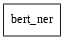

In [93]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=64)

In [97]:
def flatten_layers(root_layer):
    if isinstance(root_layer, tf.keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer

def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
      #print(layer)
      print(layer.name)
      #print(layer._layers)

In [98]:
freeze_bert_layers(ner)

bert_ner
BERT_encoder
dropout
output


In [ ]:
#####################################################################

### Set up the optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). As described in the prodecure of [Fine-Tuning Bert in Tensorflow Tutorials](https://www.tensorflow.org/official_models/fine_tuning_bert#set_up_the_optimizer): "BERT adopts the Adam optimizer with weight decay (aka "AdamW"). It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0."

In [ ]:
# set_up steps

steps_per_epoch = int(train_size / BATCH_SIZE)

num_train_steps = steps_per_epoch * EPOCHS

warmup_steps = int(WARM_UP_PROPORTION * num_train_steps)

print(warmup_steps)

It is commonly observed that a monotonically decreasing learning rate, whose degree of change is carefully chosen, results in a better performing model (source [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay)). The PolynomialDecay schedule applies a polynomial decay function to an optimizer step, given a provided initial_learning_rate, to reach an end_learning_rate in the given decay_steps. 

The base learning rate schedule used here is a linear decay to zero over the training run, visible also on the graph below :

In [ ]:
decay_schedule  = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=LEARNING_RATE,
                                                                 decay_steps=num_train_steps,
                                                                 end_learning_rate=0.0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])
plt.xlabel('number of training steps')
plt.ylabel('learning rate decay schedule')
plt.show()

Using `nlp.optimization` `WarmUp` class, the definition of the warm-up schedule is the following:

In [ ]:
warmup_schedule = WarmUp(initial_learning_rate=decay_schedule(warmup_steps),
                         decay_schedule_fn=decay_schedule,
                         warmup_steps=warmup_steps)
  
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])
plt.xlabel('number of training steps')
plt.ylabel('learning rate with warm-up and decay schedule')
plt.show()

It warms up to the `initial_learning_rate` following the learning rate level at the moment the decay schedule calculates it depending on the number of training steps.

In [ ]:
optimizer = AdamWeightDecay(
            learning_rate=warmup_schedule,
            weight_decay_rate=WEIGHT_DECAY,
            epsilon=ADAM_EPSILON,
            exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])
# default values: beta_1=0.9, beta_2=0.999,

In [ ]:
type(optimizer)

### Select loss and metrics

Select metrics to measure the loss and the accuracy of the model it the next step. These metrics accumulate the values over epochs and then print the overall result. Generally, no matter the dataset, the performance of the NER system is commonly measured by the F1-score.

F1 score is the harmonic mean of precision and recall. Output range is `[0, 1]`.
$$F_1 = 2 . \frac{precision . recall}{recision + recall}$$

In the `tensorflow_addons.metrics` module `F1Score` exists as ready-to-use option.

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

f1_metric = F1Score(OUT_UNITS, average='macro')

In [ ]:
def dice_loss(y_true, y_predicted):

    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_predicted)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)
    
    return (2. * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

    # num_sum = 2.0 * tf.reduce_sum(y_true * y_predicted) + tf.keras.backend.epsilon()
    # den_sum = tf.reduce_sum(y_true) + tf.reduce_sum(y_predicted) + tf.keras.backend.epsilon()
    # # den_sum = tf.reduce_sum(tf.square(y_predicted)) + tf.reduce_sum(tf.square(y_true)) + tf.keras.backend.epsilon()

    # return np.ndarray([1 - num_sum/den_sum], dtype = 'float32')

loss = dice_loss

The function `train_step` will be responsible on each epoch to:
1. iterate over each example in the training Dataset grabbing its features (x) and label (y).
2. Using the example's features, make a prediction and compare it with the label. To be able to compare it correctly the label_mask shouls be applied.
3. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use the optimizer to update the model's variables.

In [ ]:
 def train_step(input_ids, input_mask, segment_ids, valid_ids, label_ids, label_mask, loss_fct=loss):

  with tf.GradientTape() as tape:
      logits = ner(input_ids, input_mask, segment_ids, valid_ids, training=True)
        # batchsize, max_seq_length, num_labels
      label_ids_masked = tf.boolean_mask(label_ids, label_mask)
      logits_masked = tf.boolean_mask(logits, label_mask)
      scce_loss = loss_fct(label_ids_masked, logits_masked)

  gradients = tape.gradient(scce_loss, ner.trainable_variables)
  optimizer.apply_gradients(list(zip(gradients, ner.trainable_variables)))
  return scce_loss

In [ ]:
print(tf.config.list_physical_devices('GPU'))

### Training the model

In [ ]:
for epoch in range(1):
  epoch_loss_avg = tf.keras.metrics.Mean()
  
  # Training loop - using batches
  for (input_ids, input_mask, segment_ids, valid_ids, label_ids, label_mask) in batched_train_data:
    max_seq_len = 128
    l_input_ids      = tf.keras.layers.Input(shape=(max_seq_len,), dtype='int32')
    l_token_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype='int32')

    output = l_bert([l_input_ids, l_token_type_ids])          # [batch_size, max_seq_len, hidden_size]
    model = tf.keras.Model(inputs=[l_input_ids, l_token_type_ids], outputs=output)
    model.build(input_shape=[(None, max_seq_len), (None, max_seq_len)])
    
    # loss = train_step(input_ids, input_mask, segment_ids, valid_ids, label_ids, label_mask)

    # epoch_loss_avg.update_state(loss)
    # f1_metric.update_state()
    print(f'loss : {epoch_loss_avg.result()}')

## Entity Linking

The Entity Linking (EL) process transforms amiguous textual mention to a unique identifier by looking at the context in which the mention occurs. Thus it can be looked as 2 step process after the NER:
1. Creation of Entity Linker - list of candidates for each mention generation
2. Reduce the list to the final ID that represents the correct name.

This is generally the method used in `spacy` module.

Another option used for this is used in `deeppavlov` module (http://docs.deeppavlov.ai/en/master/features/models/entity_linking.html)where:
1. NER is fed to tf-idf Vectorizer and the resulting sparse vector is converted to dense vector.
2. A library called Faiss (https://github.com/facebookresearch/faiss) is used to find the k-nearest neighbours for tf-idf vector in the matrix where each row is a tf-idf vectors of words in entity titles.
3. entities are ranked by number of relations in Wikidata (number of outgoing edges of nodes in the knowledge graph).

## Conclusion and Future Work

Conclusion

## Ressources

**Reconstructing NER Corpora: a Case Study on Bulgarian** - Iva Marinova, Laska Laskova, Petya Osenova, Kiril Simov, Alexander Popov - Proceedings of the 12th Conference on Language Resources and Evaluation (LREC 2020), pages 4647–4652, Marseille, 11–16 May 2020

**Tuning Multilingual Transformers for Named Entity Recognition on
Slavic Languages** - Mikhail Arkhipov, Maria Trofimova, Yuri Kuratov, Alexey Sorokin - Neural Networks and Deep Learning Laboratory, Moscow Institute of Physics and Technology, Faculty of Mathematics and Mechanics, Moscow State University - Proceedings of the 7th Workshop on Balto-Slavic Natural Language Processing, pages 89–93, Florence, Italy, 2 August 2019. - https://www.aclweb.org/anthology/W19-3712.pdf


**BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding** - Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova - Google AI Language, 24 May 2019 - https://arxiv.org/pdf/1810.04805.pdf - https://github.com/google-research/bert


**Attention Is All You Need** - Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin, 6 Dec 2017 - https://arxiv.org/pdf/1706.03762.pdf

**A Survey on Deep Learning for Named Entity Recognition** - Jing Li, Aixin Sun, Jianglei Han, and Chenliang Li - IEEE TRANSACTIONS ON KNOWLEDGE AND DATA ENGINEERING, 18 Mar 2020 - https://arxiv.org/pdf/1812.09449v3.pdf

**Zero-Resource Cross-Domain Named Entity Recognition** - Zihan Liu, Genta Indra Winata, Pascale Fung - Center for Artificial Intelligence Research (CAiRE), Department of Electronic and Computer Engineering, The Hong Kong University of Science and Technology, Clear Water Bay, Hong Kong, 19 May 2020 - https://arxiv.org/pdf/2002.05923.pdf

**Exploring Cross-sentence Contexts for Named Entity Recognition with BERT** - Jouni Luoma, Sampo Pyysalo - Turku NLP group, University of Turku, Finland, 2 Jun 2020 - https://arxiv.org/pdf/2006.01563v1.pdf

**NER with BERT in Action** - Bill Huang - July 30, 2019- https://medium.com/@yingbiao/ner-with-bert-in-action-936ff275bc73

**The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)** - Jay Alammar blog - http://jalammar.github.io/illustrated-bert/

**Deep contextualized word representations** - Matthew E. Peters, Mark Neumann, Mohit Iyyer, Matt Gardner, Christopher Clark, Kenton Lee, Luke Zettlemoyer - Allen Institute for Artificial Intelligence and Paul G. Allen School of Computer Science & Engineering, University of Washington, 22 Mar 2018 - https://arxiv.org/pdf/1802.05365.pdf


**Improving Language Understanding by Generative Pre-Training** - Alec Radford, Karthik Narasimhan, Tim Salimans, Ilya Sutskever - Open AI - https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

**Introduction to the conll-2003 shared task: Language independent named entity recognition.** - Tjong Kim Sang, E. F. and De Meulder, F. (2003) - https://arxiv.org/pdf/cs/0306050.pdf

**Large-Scale Multi-Label Text Classification on EU Legislation** - Ilias Chalkidis, Manos Fergadiotis, Prodromos Malakasiotis,
Ion Androutsopoulos - Department of Informatics, Athens University of Economics and Business, Greece (June 2019) - https://arxiv.org/pdf/1906.02192v1.pdf